In [1]:
import pickle
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

## Plotting loss distributions

In [2]:
def load_losses(run_name):
    with open(os.path.join("data", "filtering-stats", run_name, "sampled_unfiltered_losses.pkl"), "rb") as f:
        unfiltered_losses = pickle.load(f)
    with open(os.path.join("data", "filtering-stats", run_name, "sampled_filtered_losses.pkl"), "rb") as f:
        filtered_losses = pickle.load(f)
    
    return [unfiltered_losses, filtered_losses]

In [3]:
mpt_sd_17_losses = load_losses("mpt-sd-17")
mpt_sd_42_losses = load_losses("mpt-sd-42")
dolma_sd_17_losses = load_losses("dolma-sd-17")
dolma_sd_42_losses = load_losses("dolma-sd-42")
pile_sd_17_losses = load_losses("pile-sd-17")
pile_sd_42_losses = load_losses("pile-sd-42")

In [4]:
mpt_unfiltered_losses = mpt_sd_17_losses[0] + mpt_sd_42_losses[0]
mpt_filtered_losses = mpt_sd_17_losses[1] + mpt_sd_42_losses[1]

dolma_unfiltered_losses = dolma_sd_17_losses[0] + dolma_sd_42_losses[0]
dolma_filtered_losses = dolma_sd_17_losses[1] + dolma_sd_42_losses[1]

pile_unfiltered_losses = pile_sd_17_losses[0] + pile_sd_42_losses[0]
pile_filtered_losses = pile_sd_17_losses[1] + pile_sd_42_losses[1]

In [5]:
def convert_to_log_pplx(samples):
    return [x / 2048 for x in samples]

In [6]:
mpt_unfiltered_losses = convert_to_log_pplx(mpt_unfiltered_losses)
mpt_filtered_losses = convert_to_log_pplx(mpt_filtered_losses)

dolma_unfiltered_losses = convert_to_log_pplx(dolma_unfiltered_losses)
dolma_filtered_losses = convert_to_log_pplx(dolma_filtered_losses)

pile_unfiltered_losses = convert_to_log_pplx(pile_unfiltered_losses)
pile_filtered_losses = convert_to_log_pplx(pile_filtered_losses)

In [7]:
colors = [
    "#EE3932",
    "#241E4E",
]
background = "#EEEDE9"
subplot_labels = ["(a)", "(b)", "(c)"]

def plot_pplx_dist(groups, save_name=""):
    # Calculate the number of rows needed for the subplots
    rows = len(groups) // 2
    cols = 4
    
    fig = plt.figure(figsize=(20, 6*rows))
    gs = gridspec.GridSpec(rows, cols, figure=fig)

    # fig, axs = plt.subplots(rows, 2, figsize=(20, 6*rows))  # Create a grid of subplots

    # # Flatten the axs array for easy iteration
    # axs = axs.flatten()

    # Iterate over each category (metric)
    for i, group in enumerate(groups):

        if i == len(groups) - 1 and len(groups) % 2 != 0:
            ax = fig.add_subplot(gs[-1, 1:3])
        else:
            ax = fig.add_subplot(gs[i // cols, 2*(i % cols) : 2*(i % cols + 1)])
    
        title = group["title"]
        group_results = group["results"]

        # Iterate over each run
        for result_idx, result_set in enumerate(group_results):
            run_name = result_set["run_name"]
            losses = result_set["losses"]
        
            sns.kdeplot(losses, fill=True, label=run_name, color=colors[result_idx], ax=ax, zorder=2, cut=0)
        
        ax.legend(loc="upper right", frameon=True, fontsize=21)

        # Label information
        ax.set_ylabel("Density", fontsize=20)
        ax.set_xlabel("Log Perplexity", fontsize=20)
        ax.set_xlim(left=0)
        ax.set_title(title, fontsize=24, fontweight="bold", pad=20)

        # Change background color
        ax.set_facecolor(background) 
        ax.grid(True, color='white', zorder=1)

        # Remove the borders from the graph
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # Format the ticks
        ax.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelsize=16)

        # Label subplot
        ax.text(0, 1.1, subplot_labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    plt.tight_layout()

    # Save the figure to disk
    if save_name:
        plt.savefig(save_name)

    plt.show()

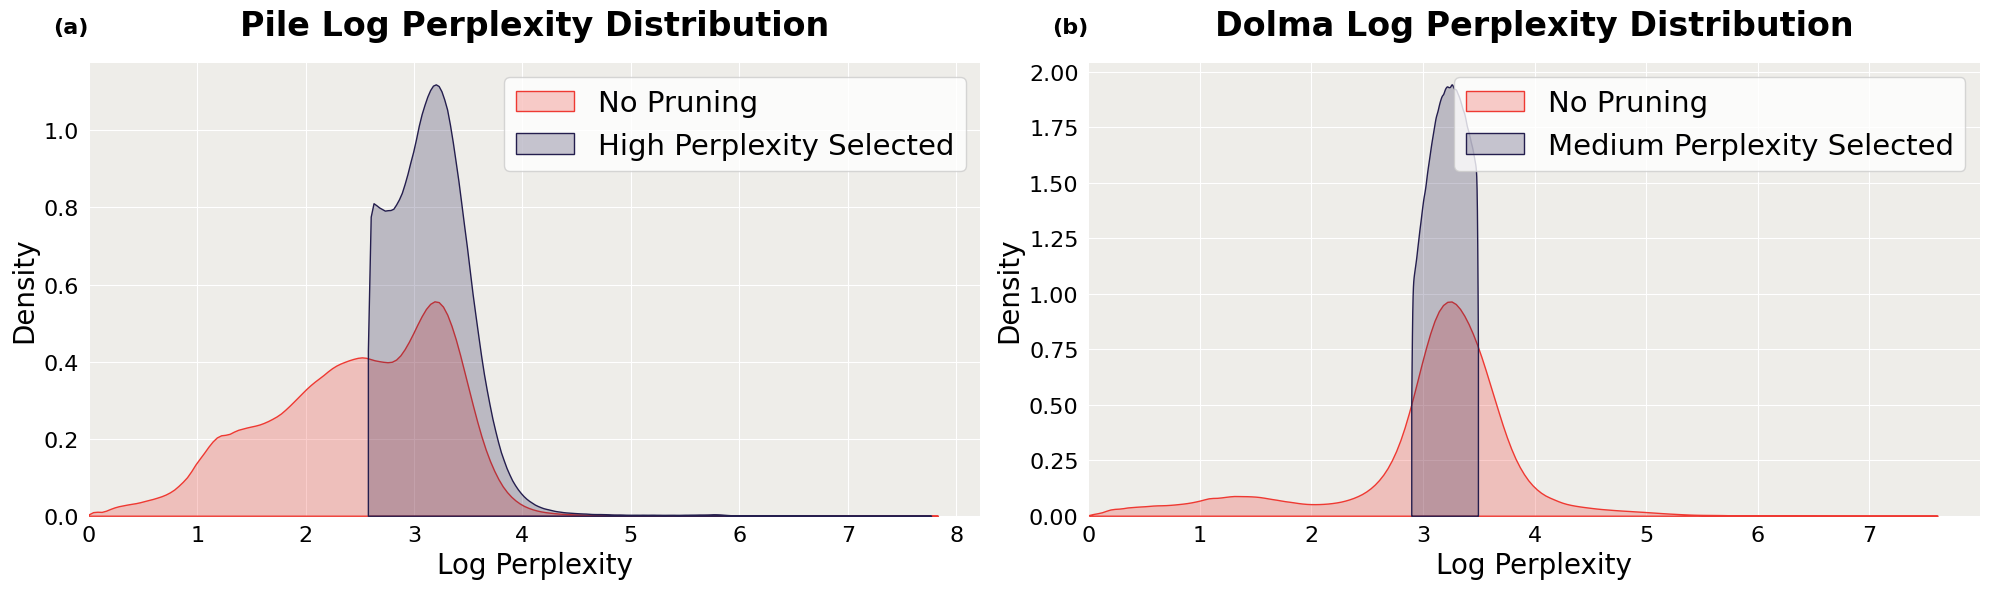

In [8]:
to_plot = [
    {
        "title": "Pile Log Perplexity Distribution",
        "results": [
            {
                "run_name": "No Pruning",
                "losses": pile_unfiltered_losses
            },
            {
                "run_name": "High Perplexity Selected",
                "losses": pile_filtered_losses
            },
        ],
    },
    {
        "title": "Dolma Log Perplexity Distribution",
        "results": [
            {
                "run_name": "No Pruning",
                "losses": dolma_unfiltered_losses
            },
            {
                "run_name": "Medium Perplexity Selected",
                "losses": dolma_filtered_losses
            },
        ],
    },
    # {
    #     "title": "WDD Perplexity Distribution",
    #     "results": [
    #         {
    #             "run_name": "No Pruning",
    #             "losses": mpt_unfiltered_losses
    #         },
    #         {
    #             "run_name": "Medium Perplexity Selected",
    #             "losses": mpt_filtered_losses
    #         },
    #     ],
    # },
]
plot_pplx_dist(to_plot, "figs/pplx-dist.pdf")

# Plotting domain distributions

In [14]:
with open("data/filtering-stats/pile_token_counts.json", "r") as f:
    pile_og_token_counts = json.load(f)
with open("data/filtering-stats/dolma_token_counts.json", "r") as f:
    dolma_og_token_counts = json.load(f)
with open("data/filtering-stats/wdd_token_counts.json", "r") as f:
    mpt_og_token_counts = json.load(f)

In [15]:
pile_og_proportions = {k: v / sum(pile_og_token_counts.values()) for k, v in pile_og_token_counts.items()}
dolma_og_proportions = {k: v / sum(dolma_og_token_counts.values()) for k, v in dolma_og_token_counts.items()}
mpt_og_proportions = {k: v / sum(mpt_og_token_counts.values()) for k, v in mpt_og_token_counts.items()}

In [16]:
sorted_pile_keys = sorted(pile_og_proportions.keys(), key=lambda x: pile_og_proportions[x], reverse=True)
sorted_dolma_keys = sorted(dolma_og_proportions.keys(), key=lambda x: dolma_og_proportions[x], reverse=True)
sorted_mpt_keys = sorted(mpt_og_proportions.keys(), key=lambda x: mpt_og_proportions[x], reverse=True)

pile_og_proportions = {k: pile_og_proportions[k] for k in sorted_pile_keys}
dolma_og_proportions = {k: dolma_og_proportions[k] for k in sorted_dolma_keys}
mpt_og_proportions = {k: mpt_og_proportions[k] for k in sorted_mpt_keys}

In [17]:
def load_proportions(run_name):
    with open(os.path.join("data", "filtering-stats", run_name, "filtered_domain_composition.pkl"), "rb") as f:
        domain_proportions = pickle.load(f)
    
    return domain_proportions

In [18]:
pile_sd_17_proportions = load_proportions("pile-sd-17")
pile_sd_42_proportions = load_proportions("pile-sd-42")
dolma_sd_17_proportions = load_proportions("dolma-sd-17")
dolma_sd_42_proportions = load_proportions("dolma-sd-42")
mpt_sd_17_proportions = load_proportions("mpt-sd-17")
mpt_sd_42_proportions = load_proportions("mpt-sd-42")

In [19]:
pile_filtered_proportions = {k: 1/2 * (pile_sd_17_proportions[k] + pile_sd_42_proportions[k]) for k in sorted_pile_keys}
dolma_filtered_proportions = {k: 1/2 * (dolma_sd_17_proportions[k] + dolma_sd_42_proportions[k]) for k in sorted_dolma_keys}
mpt_filtered_proportions = {k: 1/2 * (mpt_sd_17_proportions[k] + mpt_sd_42_proportions[k]) for k in sorted_mpt_keys}

In [20]:
colors = [
    "#EE3932",
    "#241E4E",
]
background = "#EEEDE9"
subplot_labels = ["(a)", "(b)", "(c)"]

def plot_proportions(groups, save_name=""):
    # Calculate the number of rows needed for the subplots
    rows = 1

    rows = len(groups)  // 2
    cols = 4
    
    fig = plt.figure(figsize=(20, 8*rows))
    gs = gridspec.GridSpec(rows, cols, figure=fig)

    # fig, axs = plt.subplots(rows, 2, figsize=(20, 8*rows))  # Create a grid of subplots

    # Flatten the axs array for easy iteration
    # axs = axs.flatten()

    # Iterate over each category (metric)
    for i, group in enumerate(groups):

        if i == len(groups) - 1 and len(groups) % 2 != 0:
            ax = fig.add_subplot(gs[-1, 1:3])
        else:
            ax = fig.add_subplot(gs[i // cols, 2*(i % cols) : 2*(i % cols + 1)])
    
        title = group["title"]
        group_results = group["results"]
        sorted_keys = group["sorted_keys"]

        # Iterate over each run
        for result_idx, result_set in enumerate(group_results):
            run_name = result_set["run_name"]
            proportions = result_set["proportions"]
        
            ax.bar(sorted_keys, proportions, color=colors[result_idx], label=run_name, alpha=0.55, align="center" , zorder=2)
        
        ax.legend(loc="upper right", frameon=True, fontsize=21)

        # Label information
        ax.set_ylabel("Proportion of Dataset (%)", fontsize=20)
        ax.set_xlabel("Domains", fontsize=20)
        ax.set_title(title, fontsize=24, pad=20, fontweight="bold")

        # Change background color
        ax.set_facecolor(background) 
        ax.grid(True, color='white', zorder=1)

        # Remove the borders from the graph
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # Format the ticks
        ax.tick_params(axis='both', which='both', bottom=False, left=False, top=False, right=False, labelsize=16)
        ax.tick_params(axis='x', labelrotation=90)

        # Label subplot
        ax.text(0, 1.1, subplot_labels[i], transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

    plt.tight_layout()

    # Save the figure to disk
    if save_name:
        plt.savefig(save_name)

    plt.show()

In [21]:
list(dolma_filtered_proportions.values())

[0.853000369250046,
 0.006909041604981809,
 0.0902068768386095,
 0.023635786235055023,
 0.02233822973121194,
 0.0019593132553958866,
 0.001950383084699903]

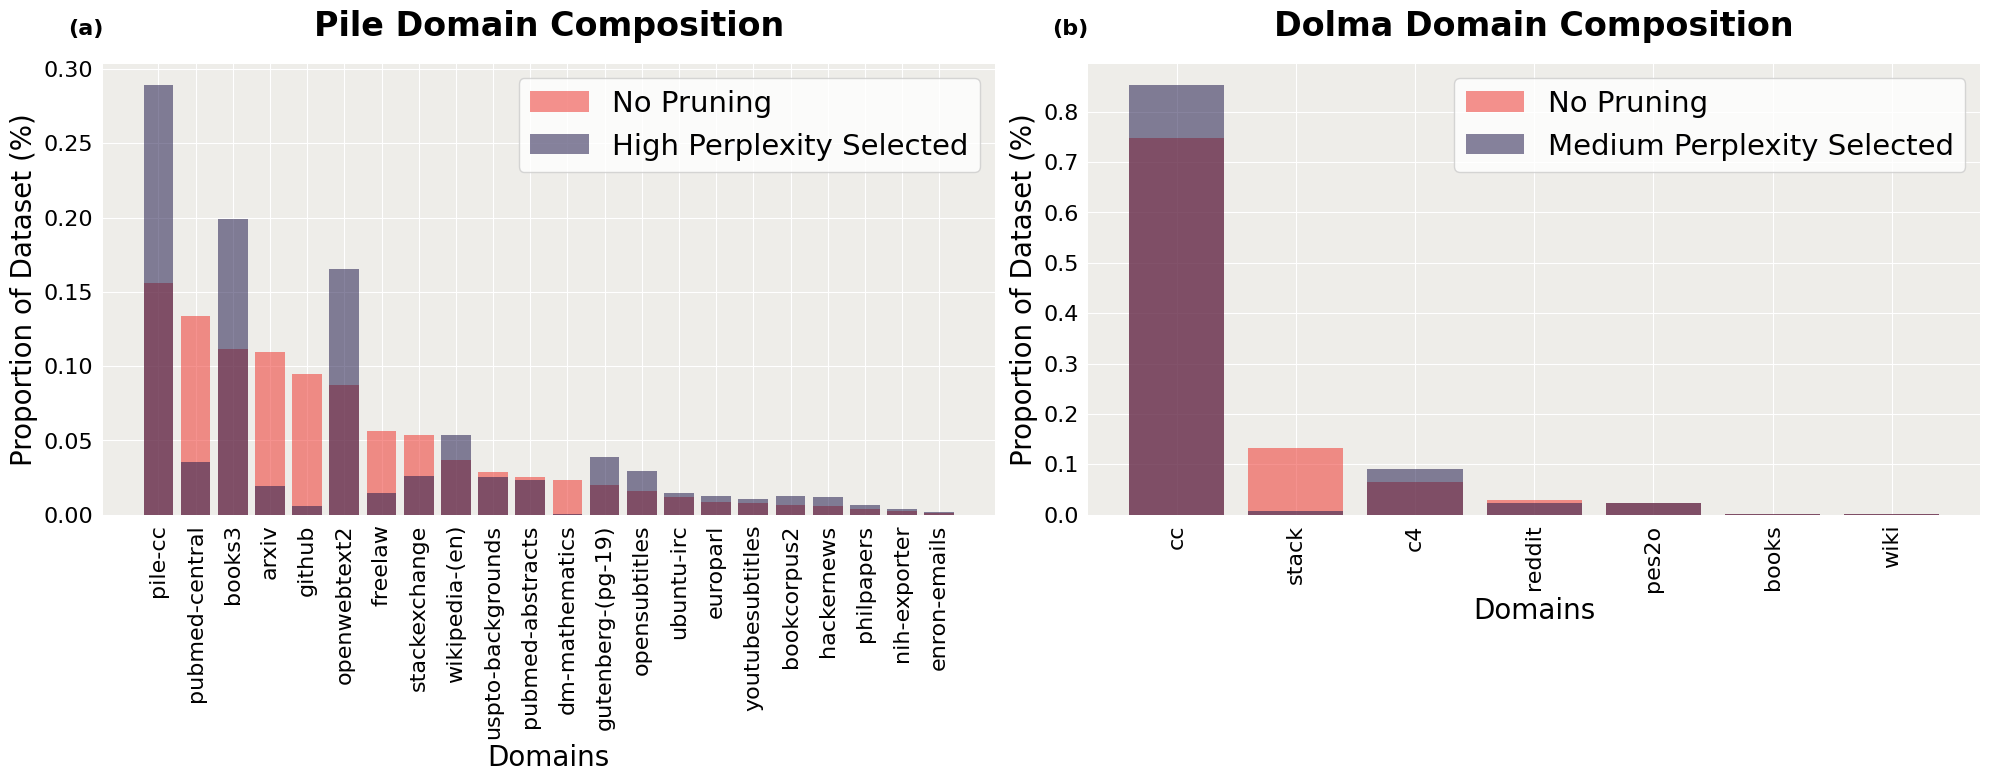

In [22]:
to_plot = [
    {
        "title": "Pile Domain Composition",
        "sorted_keys": sorted_pile_keys,
        "results": [
            {
                "run_name": "No Pruning",
                "proportions": list(pile_og_proportions.values())
            },
            {
                "run_name": "High Perplexity Selected",
                "proportions": list(pile_filtered_proportions.values())
            },
        ],
    },
    {
        "title": "Dolma Domain Composition",
        "sorted_keys": sorted_dolma_keys,
        "results": [
            {
                "run_name": "No Pruning",
                "proportions": list(dolma_og_proportions.values())
            },
            {
                "run_name": "Medium Perplexity Selected",
                "proportions": list(dolma_filtered_proportions.values())
            },
        ],
    },
    # {
    #     "title": "WDD Domain Composition",
    #     "sorted_keys": sorted_mpt_keys,
    #     "results": [
    #         {
    #             "run_name": "No Pruning",
    #             "proportions": list(mpt_og_proportions.values())
    #         },
    #         {
    #             "run_name": "Medium Perplexity Selected",
    #             "proportions": list(mpt_filtered_proportions.values())
    #         },
    #     ],
    # },
]
plot_proportions(to_plot, "figs/domain-composition.pdf")